## ASTR622 Interstellar Medium Problem Set 4
### numerically integrate the Emden-Chandrasekhar equation and plot Bonnor-Ebert density profile
$$\frac{1}{x^2}\frac{d}{dx}\left(x^2\frac{dy}{dx}\right) = e^{-y}$$

### by breaking it into a system of ODEs and using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_ivp
%matplotlib inline

In [2]:
# function to calculate the differential as required by solve_ivp
def dydx(x, y):
    dy0dx = y[1]
    dy1dx = np.exp(-y[0]) - 2*y[1]/x
    return np.array([dy0dx, dy1dx])

In [3]:
def ec_integrate2():
    # solve Emden-Chandrasekhar equation by considering it as a system of ODEs and using scipy
    # note that I needed 10x more steps than my method to make a smooth mass plot at the end
    nsteps = 10000
    tspan = (1e-2, 1e4)
    t = np.logspace(np.log10(tspan[0]), np.log10(tspan[1]), nsteps)
    sol = solve_ivp(dydx, tspan, [0,0], t_eval=t)
    return(sol)

In [4]:
def plot_ec():
    # plot solution to Emden-Chandraskehar
    sol = ec_integrate2()
    x = sol.t
    y = sol.y[0]

    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel(r'$x$', fontsize=14)
    ax1.set_ylabel(r'$y$', fontsize=14)
    ax1.plot(x, y, 'k-')

    ax2 = fig.add_subplot(122)
    ax2.set_xlim(1e-2, 1e4)
    ax2.set_ylim(1e-5,30)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$x$', fontsize=14)
    ax2.plot(x, y, 'k-')

    fig.tight_layout() 
    plt.savefig('ec_solution.pdf')

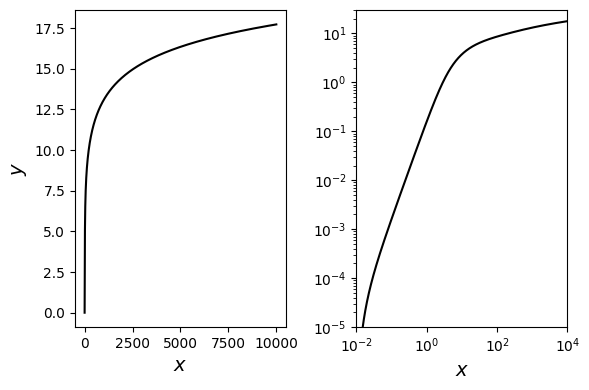

In [5]:
# show solution to equation in normalized variables
plot_ec()

In [6]:
def plot_profiles():
    # plot Bonnor-Ebert density profile  
    sol = ec_integrate2()
    x = sol.t
    y = sol.y[0]
    
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)

    ax.set_xlim(0.002,1.0)
    ax.set_ylim(1e8,1e13)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'${\rm Radius}\ {\rm (pc)}$', fontsize=14)
    ax.set_ylabel(r'${\rm H_2\ density}\ {\rm (m^{-3})}$', fontsize=14)

    T = 10                                   # isothermal temperature (K)

    n0 = np.array([1,10,100,1000])*1e9       # central density in m-3
    ls = ['-','-','-','-']
    lw = [2,2,2,2]
    alpha = [0.3,0.3,0.3,0.3]
    nlabels = [r'$10^9\,{\rm m}^{-3}$', r'$10^{10}$', r'$10^{11}$', r'$10^{12}$']

    for i in range(len(n0)):
        r = 1243 * np.sqrt(T/n0[i]) * x
        n = n0[i] / np.exp(y)
        ax.plot(r, n, linestyle=ls[i], lw=lw[i], label=nlabels[i])

    # singular isothermal sphere
    r = np.logspace(-3,1,2)
    SIS_profile = 3.09e6 * T / r**2
    ax.plot(r, SIS_profile, 'k--', lw=2, label='Singular')
    ax.legend()

    x_labels = ['0.01','0.1','1']
    x_loc = np.array([float(xl) for xl in x_labels])
    ax.set_xticks(x_loc)
    ax.set_xticklabels(x_labels)

    fig.tight_layout() 
    plt.savefig('bonnor_ebert_profiles.pdf')

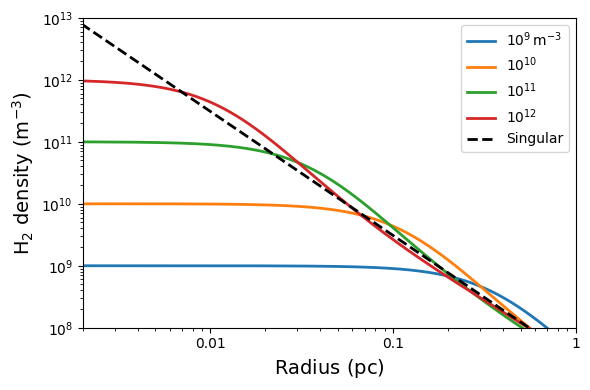

In [7]:
# reproduce Figure 9.1
plot_profiles()

In [8]:
def plot_mass():
    # plot mass for given P_ext
    sol = ec_integrate2()
    x = sol.t
    y = sol.y[0]

    T = 10              # isothermal temperature (K)
    n_ext = 8e9/T       # exterior density in m-3

    n0 = np.logspace(np.log10(1.1*n_ext),12,300)
    ndens = n0.size
    r_ext = np.zeros(ndens)
    m_ext = np.zeros(ndens)
    m_tot = np.zeros(ndens)
    for i in range(ndens):
        y_ext = np.log(n0[i]/n_ext)
        x_ext = x[np.argmin(np.abs(y - y_ext))]
        k = np.where(x < x_ext)[0]
        m_ext[i] = 1196 * np.sqrt(T**3/n0[i]) * integrate.simps(x[k]**2 * np.exp(-y[k]), x[k])

    # max pressure contrast
    Pratio = n0/n_ext
    imax = m_ext.argmax()
    m_ext_max = m_ext[imax]
    Pratio_max = Pratio[imax]
    print(f"Maximum pressure ratio = {Pratio_max:5.2f} at mass = {m_ext_max:5.2f} solar masses")

    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)

    ax1.set_xlim(1,3e2)
    ax1.set_xscale('log')
    ax1.set_xlabel(r'$\rho_{\rm cen}/\rho_{\rm amb}$', fontsize=14)
    ax1.set_ylim(0,6.5)
    ax1.set_ylabel(r'${\rm Mass}\ (M_\odot)$', fontsize=14)
    ax1.plot(Pratio, m_ext, 'k-', lw=2)
    ax1.vlines(Pratio_max, 0, 10, linestyle='dotted')
    ax1.hlines(m_ext_max, 0, 300, linestyle='dotted')

    fig.tight_layout() 
    plt.savefig('bonnor_ebert_mass.pdf')

Maximum pressure ratio = 13.01 at mass =  5.55 solar masses


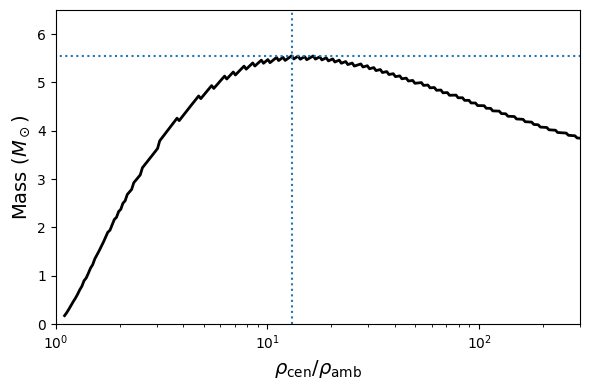

In [9]:
# reproduce Figure 9.2
plot_mass()